# Installing libraries

In [1]:
!pip install tensorflow-docs livelossplot keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


# Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from kerastuner.tuners import RandomSearch
from livelossplot import PlotLossesKeras

# Function to plot predictions


In [ ]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(10, 5))
    plt.plot(test, color='red', label='Real IBM Stock Price')
    plt.plot(predicted, color='blue', label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

# Load dataset


In [ ]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

# Scaling the data


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

# Creating data structure with 60 timesteps


In [ ]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define the model building function for Keras Tuner


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=30, max_value=100, step=10),
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=30, max_value=100, step=10), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up the tuner


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='stock_price_optimization'
)

# Callbacks for monitoring and improving the model


In [17]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_best.h5', monitor='val_loss', save_best_only=True),
    PlotLossesKeras()

]

# Search for the best hyperparameter configuration


In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=callbacks, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model with test data


In [ ]:
inputs = dataset["High"].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(len(inputs) - 60):
    X_test.append(inputs[i:i+60, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = best_model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Plot the results


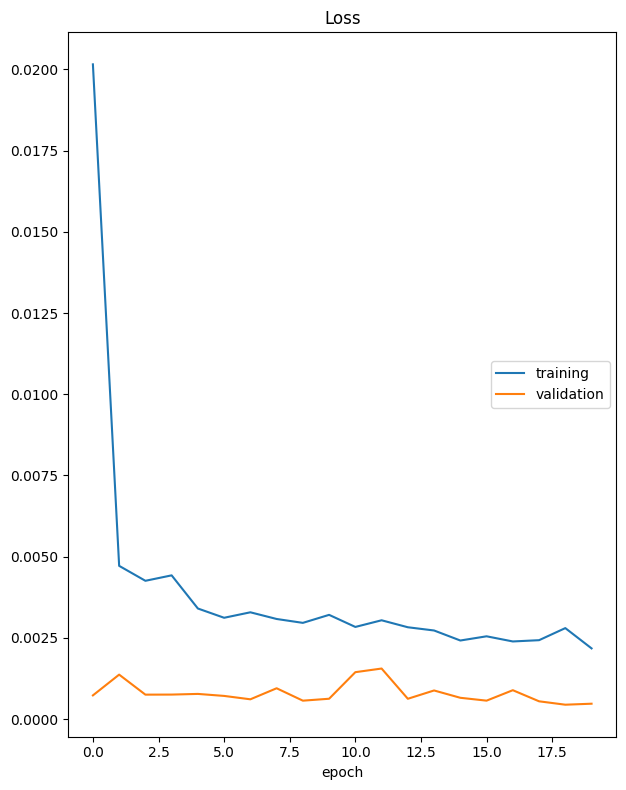

Loss
	training         	 (min:    0.002, max:    0.020, cur:    0.002)
	validation       	 (min:    0.000, max:    0.002, cur:    0.000)
93/93 [==============================] - 3s 27ms/step


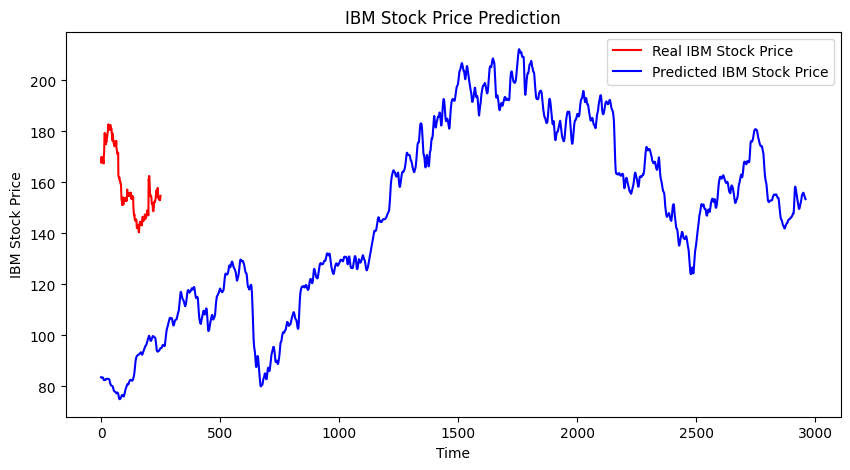

In [2]:
plot_predictions(test_set, predicted_stock_price)

# Get the best hyperparameters


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters


In [ ]:
print("Best Hyperparameters:")
print("Units:", best_hyperparameters.get('units'))
print("Dropout 1:", best_hyperparameters.get('dropout_1'))
print("Dropout 2:", best_hyperparameters.get('dropout_2'))

# Get the best model


In [ ]:
best_model = keras.models.load_model('model_best.h5')


In [5]:
# Print the model summary
best_model.summary()

Best Hyperparameters:
Units: 90
Dropout 1: 0.2
Dropout 2: 0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 80)            26240     
                                                                 
 dropout (Dropout)           (None, 60, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 77841 (304.07 KB)
Trainable params: 77841 (304.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [4]:
# prompt: print the randomsearch's resutls
print(tuner.results_summary())


Results summary
Results in keras_tuner_dir/stock_price_optimization
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
units: 90
dropout_1: 0.2
dropout_2: 0.1
Score: 0.0004048234550282359

Trial 04 summary
Hyperparameters:
units: 100
dropout_1: 0.5
dropout_2: 0.5
Score: 0.0004429851833265275

Trial 09 summary
Hyperparameters:
units: 80
dropout_1: 0.4
dropout_2: 0.30000000000000004
Score: 0.0004470659769140184

Trial 00 summary
Hyperparameters:
units: 60
dropout_1: 0.4
dropout_2: 0.2
Score: 0.0004594464262481779

Trial 07 summary
Hyperparameters:
units: 90
dropout_1: 0.4
dropout_2: 0.1
Score: 0.0004856386221945286

Trial 08 summary
Hyperparameters:
units: 40
dropout_1: 0.2
dropout_2: 0.4
Score: 0.0005128367920406163

Trial 03 summary
Hyperparameters:
units: 40
dropout_1: 0.1
dropout_2: 0.30000000000000004
Score: 0.0005189781659282744

Trial 01 summary
Hyperparameters:
units: 60
dropout_1: 0.5
dropout_2: 0.5
Score: 0.0005378242931328714


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate metrics
mae = mean_absolute_error(test_set, predicted_stock_price[:251])
mse = mean_squared_error(test_set, predicted_stock_price[:251])
r2 = r2_score(test_set, predicted_stock_price[:251])

In [18]:
print("Mae: ", mae)
print("MSE: ", mae)
print("R2 Score: ", r2)

Mae:  158.430397209686
MSE:  158.430397209686
R2 Score:  -169.7199818042632


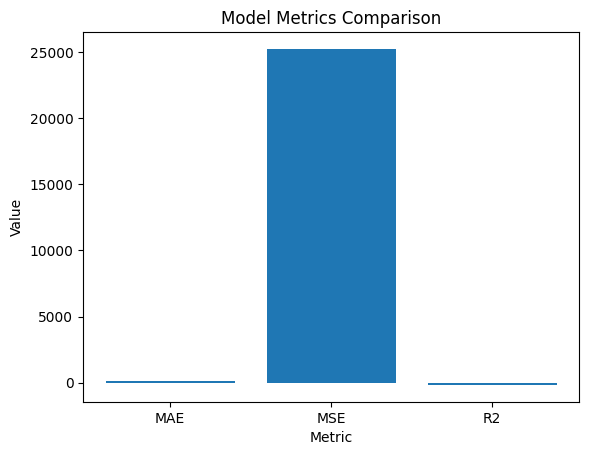

In [15]:
import matplotlib.pyplot as plt

# Define bar labels
bar_labels = ['MAE', 'MSE', 'R2']

# Define bar values
bar_values = [mae, mse, r2]

# Create the figure and axes
fig, ax = plt.subplots()

# Create the bar plot
ax.bar(bar_labels, bar_values)

# Add title and labels
ax.set_title('Model Metrics Comparison')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Show the plot
plt.show()
